In [69]:
import numpy as np
import pandas as pd
from time import time
import re, string, unicodedata
from collections import defaultdict
import multiprocessing

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# cleaning and preprocessing
from contractions import CONTRACTION_MAP
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize

# bigrams
from gensim.models.phrases import Phrases, Phraser

# Word2Vec
from gensim.models import Word2Vec

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# logging to monitor gensim
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Dataset

In [2]:
df = pd.read_csv('https://query.data.world/s/nu4cetyeefkjloxph4ytsbis5zejjg'); df.head()

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [3]:
df.shape

(59909, 7)

In [4]:
# filtering columns
COLUMNS = ["speaker", "line_text"]
df = df[COLUMNS];
df.tail(2)

,speaker,line_text
59907,Jim,I sold paper at this company for 12 years. My ...
59908,Pam,I thought it was weird when you picked us to m...


In [5]:
# null check
df.isnull().sum()

speaker      0
line_text    0
dtype: int64

## Cleaning

Cleaning pipeline consists of:

- Expanding contractions (y'all -> you all)
- Lowercase
- Remove punctuations, stopwords, special characters, non-alphanumeric
- Lemmatization

In [6]:
# Contractions helper function
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [7]:
df['contracted'] = df['line_text'].apply(lambda x: expand_contractions(x))

In [8]:
# Tokenizing
def tokenize(text):
    tweet_tokens = re.split('\W+', text)
    return tweet_tokens

In [9]:
df['tokens'] = df['contracted'].apply(lambda x: tokenize(x)).values

In [10]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, get_wordnet_pos(word))
        lemmas.append(lemma)
    return lemmas

In [11]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words

In [12]:
df['normalize'] = df['tokens'].apply(lambda x: normalize(x))

In [13]:
df.head()

,speaker,line_text,contracted,tokens,normalize
0,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...,"[All, right, Jim, Your, quarterlies, look, ver...","[right, jim, quarterly, look, good, thing, lib..."
1,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I could not close it. So...","[Oh, I, told, you, I, could, not, close, it, S...","[oh, told, could, close]"
2,Michael,So you've come to the master for guidance? Is ...,So you have come to the master for guidance? I...,"[So, you, have, come, to, the, master, for, gu...","[come, master, guidance, say, grasshopper]"
3,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah.","[Actually, you, called, me, in, here, but, yea...","[actually, call, yeah]"
4,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it is done.","[All, right, Well, let, me, show, you, how, it...","[right, well, let, show, do]"


In [14]:
# Stitching together
tokens = []
for i,d in enumerate(df['normalize']):
    tokens.append(' '.join(d))
    
df['clean_text'] = tokens

In [15]:
df.head()

,speaker,line_text,contracted,tokens,normalize,clean_text
0,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...,"[All, right, Jim, Your, quarterlies, look, ver...","[right, jim, quarterly, look, good, thing, lib...",right jim quarterly look good thing library
1,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I could not close it. So...","[Oh, I, told, you, I, could, not, close, it, S...","[oh, told, could, close]",oh told could close
2,Michael,So you've come to the master for guidance? Is ...,So you have come to the master for guidance? I...,"[So, you, have, come, to, the, master, for, gu...","[come, master, guidance, say, grasshopper]",come master guidance say grasshopper
3,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah.","[Actually, you, called, me, in, here, but, yea...","[actually, call, yeah]",actually call yeah
4,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it is done.","[All, right, Well, let, me, show, you, how, it...","[right, well, let, show, do]",right well let show do


In [16]:
df.shape

(59909, 6)

In [17]:
# null check
df.isnull().sum()

speaker       0
line_text     0
contracted    0
tokens        0
normalize     0
clean_text    0
dtype: int64

## Bigrams

In [18]:
# Phrases() takes a list of words as input; so passing column 'normalize'
sent = [w for w in df['normalize']]

In [19]:
# Create relevant phrases from list of sentences
phrases = Phrases(sent, min_count=10, progress_per=5000)

INFO - 10:26:06: collecting all words and their counts
INFO - 10:26:06: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 10:26:06: PROGRESS: at sentence #5000, processed 28759 words and 22892 word types
INFO - 10:26:06: PROGRESS: at sentence #10000, processed 56658 words and 41058 word types
INFO - 10:26:06: PROGRESS: at sentence #15000, processed 83948 words and 57678 word types
INFO - 10:26:06: PROGRESS: at sentence #20000, processed 113156 words and 74958 word types
INFO - 10:26:06: PROGRESS: at sentence #25000, processed 142341 words and 91066 word types
INFO - 10:26:06: PROGRESS: at sentence #30000, processed 169750 words and 105143 word types
INFO - 10:26:06: PROGRESS: at sentence #35000, processed 197084 words and 119044 word types
INFO - 10:26:06: PROGRESS: at sentence #40000, processed 224977 words and 133115 word types
INFO - 10:26:06: PROGRESS: at sentence #45000, processed 253953 words and 147463 word types
INFO - 10:26:06: PROGRESS: at sentence #50000, p

In [26]:
phrases[['michael', 'scott']]

['michael_scott']

In [27]:
bigram = Phraser(phrases)

INFO - 10:30:50: source_vocab length 191100
INFO - 10:30:52: Phraser built with 280 phrasegrams


In [28]:
sentences = bigram[sent]

In [37]:
print([i for i in sentences[:10]])

[['right', 'jim', 'quarterly', 'look', 'good', 'thing', 'library'], ['oh', 'told', 'could', 'close'], ['come', 'master', 'guidance', 'say', 'grasshopper'], ['actually', 'call', 'yeah'], ['right', 'well', 'let', 'show', 'do'], ['phone', 'yes', 'would', 'like', 'speak', 'office', 'manager', 'please', 'yes', 'hello', 'michael_scott', 'regional_manager', 'dunder_mifflin', 'paper', 'product', 'want', 'talk', 'manager', 'manger', 'quick', 'cut', 'scene', 'right', 'do', 'deal', 'thank_much', 'sir', 'gentleman', 'scholar', 'oh', 'sorry', 'ok', 'sorry', 'mistake', 'hang', 'woman', 'talk', 'low', 'voice', 'probably', 'smoker', 'clear_throat', 'way', 'do'], ['uh', 'dunder_mifflin', '12', 'year', 'last', 'four', 'regional_manager', 'want', 'come', 'see', 'entire', 'floor', 'kingdom', 'far', 'eye', 'see', 'receptionist', 'pam', 'pam', 'pam', 'pam', 'pam', 'beesly', 'pam', 'u', 'forever', 'right', 'pam'], ['well', 'know'], ['think', 'cute', 'see', 'couple', 'year_ago', 'growl'], []]


## Most Frequent Words

In [38]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
len(word_freq)

16623

In [39]:
# most freq
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['go', 'get', 'know', 'oh', 'yeah', 'like', 'okay', 'well', 'right', 'michael']

In [40]:
# least freq
sorted(word_freq, key=word_freq.get, reverse=False)[:10]

['wastepaper',
 'spencer',
 'whass',
 'rodham',
 'ringie',
 'dingie',
 'packman',
 'godzillary',
 'unnecessarily',
 'daniqua']

## Training Word2Vec

In [41]:
# cores
cores = multiprocessing.cpu_count()
print(cores)

8


#### Word2Vec()

Set up the parameters.

Leaving it uninitialized purposefully by not supplying the parameter *sentences*.

In [42]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

#### .build_vocab()

Builds vocab from sequence of sentences and the model gets initialized.

In [43]:
t = time()

w2v_model.build_vocab(sentences, progress_per=5000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:38:40: collecting all words and their counts
INFO - 10:38:40: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:38:40: PROGRESS: at sentence #5000, processed 27856 words, keeping 4271 word types
INFO - 10:38:40: PROGRESS: at sentence #10000, processed 54818 words, keeping 6278 word types
INFO - 10:38:41: PROGRESS: at sentence #15000, processed 81246 words, keeping 7903 word types
INFO - 10:38:41: PROGRESS: at sentence #20000, processed 109540 words, keeping 9381 word types
INFO - 10:38:41: PROGRESS: at sentence #25000, processed 137801 words, keeping 10632 word types
INFO - 10:38:41: PROGRESS: at sentence #30000, processed 164207 words, keeping 11522 word types
INFO - 10:38:41: PROGRESS: at sentence #35000, processed 190663 words, keeping 12443 word types
INFO - 10:38:41: PROGRESS: at sentence #40000, processed 217738 words, keeping 13331 word types
INFO - 10:38:41: PROGRESS: at sentence #45000, processed 245913 words, keeping 14118 word types
INFO -

Time to build vocab: 0.02 mins


#### Training model

In [44]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:43:30: training model with 7 workers on 3446 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 10:43:31: EPOCH 1 - PROGRESS: at 67.34% examples, 79381 words/s, in_qsize 0, out_qsize 0
INFO - 10:43:31: worker thread finished; awaiting finish of 6 more threads
INFO - 10:43:31: worker thread finished; awaiting finish of 5 more threads
INFO - 10:43:31: worker thread finished; awaiting finish of 4 more threads
INFO - 10:43:31: worker thread finished; awaiting finish of 3 more threads
INFO - 10:43:31: worker thread finished; awaiting finish of 2 more threads
INFO - 10:43:31: worker thread finished; awaiting finish of 1 more threads
INFO - 10:43:31: worker thread finished; awaiting finish of 0 more threads
INFO - 10:43:31: EPOCH - 1 : training on 331128 raw words (124565 effective words) took 1.4s, 89535 effective words/s
INFO - 10:43:32: EPOCH 2 - PROGRESS: at 84.83% examples, 102368 words/s, in_qsize 0, out_qsize 0
INFO - 10:43:32: worker thread

INFO - 10:43:45: EPOCH 12 - PROGRESS: at 70.40% examples, 82787 words/s, in_qsize 0, out_qsize 0
INFO - 10:43:45: worker thread finished; awaiting finish of 6 more threads
INFO - 10:43:45: worker thread finished; awaiting finish of 5 more threads
INFO - 10:43:45: worker thread finished; awaiting finish of 4 more threads
INFO - 10:43:45: worker thread finished; awaiting finish of 3 more threads
INFO - 10:43:45: worker thread finished; awaiting finish of 2 more threads
INFO - 10:43:45: worker thread finished; awaiting finish of 1 more threads
INFO - 10:43:45: worker thread finished; awaiting finish of 0 more threads
INFO - 10:43:45: EPOCH - 12 : training on 331128 raw words (125244 effective words) took 1.4s, 91657 effective words/s
INFO - 10:43:46: EPOCH 13 - PROGRESS: at 81.87% examples, 100537 words/s, in_qsize 0, out_qsize 0
INFO - 10:43:46: worker thread finished; awaiting finish of 6 more threads
INFO - 10:43:46: worker thread finished; awaiting finish of 5 more threads
INFO - 10:4

INFO - 10:43:59: worker thread finished; awaiting finish of 6 more threads
INFO - 10:43:59: worker thread finished; awaiting finish of 5 more threads
INFO - 10:43:59: worker thread finished; awaiting finish of 4 more threads
INFO - 10:43:59: worker thread finished; awaiting finish of 3 more threads
INFO - 10:43:59: worker thread finished; awaiting finish of 2 more threads
INFO - 10:43:59: worker thread finished; awaiting finish of 1 more threads
INFO - 10:43:59: worker thread finished; awaiting finish of 0 more threads
INFO - 10:43:59: EPOCH - 23 : training on 331128 raw words (124922 effective words) took 1.2s, 106310 effective words/s
INFO - 10:44:00: EPOCH 24 - PROGRESS: at 84.83% examples, 104863 words/s, in_qsize 0, out_qsize 0
INFO - 10:44:00: worker thread finished; awaiting finish of 6 more threads
INFO - 10:44:00: worker thread finished; awaiting finish of 5 more threads
INFO - 10:44:00: worker thread finished; awaiting finish of 4 more threads
INFO - 10:44:00: worker thread f

Time to train the model: 0.63 mins


In [45]:
# make model memory efficient
w2v_model.init_sims(replace=True)

INFO - 10:44:18: precomputing L2-norms of word weight vectors


## Exploring the model

### Most similar

In [46]:
w2v_model.wv.most_similar(positive=['michael'])

[('stare', 0.9729537963867188),
 ('leaf', 0.9687976837158203),
 ('annex', 0.9599713087081909),
 ('open_door', 0.9584674835205078),
 ('quietly', 0.9564653635025024),
 ('approach', 0.9535989165306091),
 ('smile', 0.9518152475357056),
 ('excuse', 0.950378954410553),
 ('whisper', 0.9498039484024048),
 ('good_morning', 0.9494023323059082)]

In [47]:
w2v_model.wv.most_similar(positive=['michael_scott'])

[('dunder_mifflin', 0.9662973880767822),
 ('dwight_schrute', 0.9649559259414673),
 ('paper_company', 0.9605519771575928),
 ('regional_manager', 0.94254469871521),
 ('scranton_branch', 0.906741201877594),
 ('jim_halpert', 0.892410933971405),
 ('mr', 0.8759771585464478),
 ('david_wallace', 0.8752639293670654),
 ('salesman', 0.8700391054153442),
 ('introduce', 0.8636146783828735)]

In [48]:
w2v_model.wv.most_similar(positive=['jim'])

[('pam', 0.9749890565872192),
 ('shake_head', 0.9546641111373901),
 ('stare', 0.9535520672798157),
 ('quietly', 0.9495683312416077),
 ('smile', 0.946858286857605),
 ('leaf', 0.9450666904449463),
 ('annex', 0.9435120820999146),
 ('whisper', 0.9433224201202393),
 ('michael', 0.9416433572769165),
 ('nod', 0.9403144121170044)]

In [49]:
w2v_model.wv.most_similar(positive=['warehouse'])

[('license', 0.9608668088912964),
 ('friendly', 0.9606679677963257),
 ('dynamic', 0.9600046277046204),
 ('athlete', 0.9599429368972778),
 ('electric_city', 0.9589083194732666),
 ('assignment', 0.9571537375450134),
 ('effort', 0.9567835927009583),
 ('investor', 0.9567010402679443),
 ('stake', 0.9566989541053772),
 ('knight', 0.9563060402870178)]

In [50]:
w2v_model.wv.most_similar(positive=['andy_bernard'])

[('accountant', 0.9578881859779358),
 ('bernard', 0.9564452171325684),
 ('former', 0.9488400220870972),
 ('chief', 0.9441491365432739),
 ('wise', 0.944046139717102),
 ('cappella', 0.9436603784561157),
 ('signature', 0.942876935005188),
 ('andrew', 0.9413415193557739),
 ('meredith_palmer', 0.9410542249679565),
 ('compete', 0.9399938583374023)]

In [51]:
w2v_model.wv.most_similar(positive=['oscar'])

[('stanley', 0.9455965757369995),
 ('phyllis', 0.937119722366333),
 ('pat', 0.9367525577545166),
 ('cheek', 0.9356184005737305),
 ('quietly', 0.9343083500862122),
 ('gasp', 0.932079553604126),
 ('stare', 0.929178774356842),
 ('shake_head', 0.9289498925209045),
 ('nod', 0.9276914596557617),
 ('leaf', 0.9273973107337952)]

### Similarities

In [52]:
w2v_model.wv.similarity("jim", "pam")

0.97498906

In [53]:
w2v_model.wv.similarity("michael", "conference")

0.77298915

In [54]:
w2v_model.wv.similarity("dwight", "angela")

0.85950464

In [55]:
w2v_model.wv.similarity("jim", "dwight")

0.92599547

In [56]:
w2v_model.wv.similarity("andy_bernard", "cornell")

0.85918784

### Odd-One-Out

In [57]:
w2v_model.wv.doesnt_match(['jim', 'dwight', 'creed'])

/home/paperspace/anaconda3/envs/my-ml/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'creed'

In [58]:
w2v_model.wv.doesnt_match(['jim', 'dwight', 'pam'])

'dwight'

In [59]:
w2v_model.wv.doesnt_match(['michael', 'dwight', 'angela'])

'angela'

In [60]:
w2v_model.wv.doesnt_match(['andy', 'erin', 'cornell'])

'cornell'

## PCA

In [63]:
# retrieve all thr vectors from trained model
X = w2v_model[w2v_model.wv.vocab]

/home/paperspace/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [65]:
X.shape

(3446, 300)

In [66]:
# fitting PCA
pca = PCA(n_components=2)
pca_words = pca.fit_transform(X)

In [67]:
pca.explained_variance_ratio_

array([0.28385177, 0.2236942 ], dtype=float32)

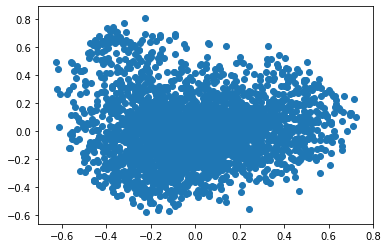

In [70]:
pc1 = pca_words[:, 0]
pc2 = pca_words[:, 1]

plt.scatter(pc1, pc2)

## t-SNE

In [72]:
%%time
pca = PCA(n_components=50, random_state=42)
pca_words = pca.fit_transform(X)
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
tsne_words = tsne.fit_transform(pca_words)

CPU times: user 26.8 s, sys: 713 ms, total: 27.5 s
Wall time: 26.5 s


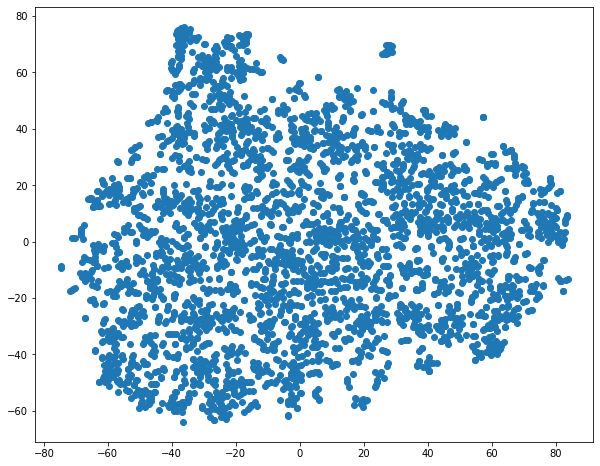

In [74]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_words[:, 0], tsne_words[:, 1])

In [87]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
 
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=16).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

### 10 most similar vs 7 random words

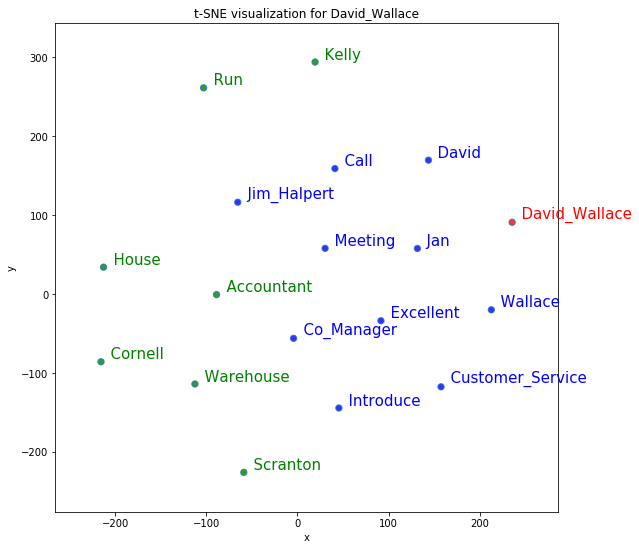

In [92]:
tsnescatterplot(w2v_model, 'david_wallace', ['cornell', 'house', 'accountant', 'warehouse',
                                             'run', 'scranton', 'kelly'])

### 10 most similar vs 10 most dissimilar

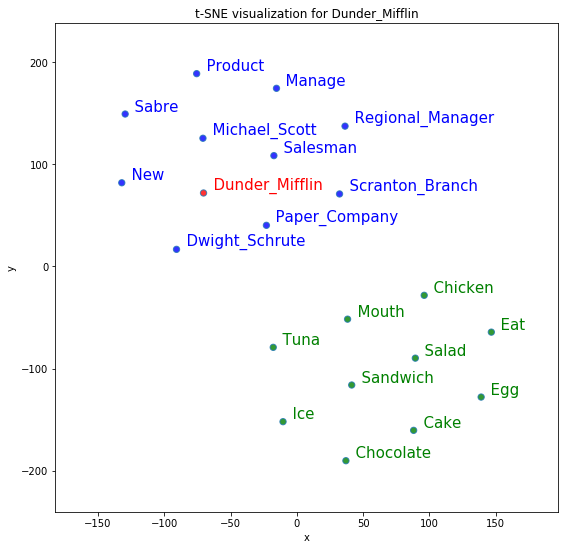

In [97]:
tsnescatterplot(w2v_model, 
                'dunder_mifflin', 
                [i[0] for i in w2v_model.wv.most_similar(negative=["dunder_mifflin"])])